In [ ]:
import numpy as np
import pandas as pd
import requests
import os
import json
import time
from glob import glob
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
api_key = '4c3dabc77ad148ae820234309251501'
city = 'Delhi, Delhi'
start_date = datetime.strptime('2010-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2025-01-21', '%Y-%m-%d')
frequency = '1'

In [ ]:
def generate_month_ranges(start, end):
    current = start
    while current <= end:
        month_end = (current.replace(day=28) + timedelta(days=4)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        yield current, month_end
        current = month_end + timedelta(days=1)

In [ ]:
os.makedirs('./data', exist_ok=True)

## Downloading data

In [ ]:
for start, end in tqdm(generate_month_ranges(start_date, end_date), desc="Downloading data"):
    file_path = f'./data/weather_{city}_{start.strftime("%Y_%m")}.json'

    if os.path.exists(file_path):
        print(f"File for {start.strftime('%Y-%m')} already exists. Skipping download.")
        continue

    url = (f'http://api.worldweatheronline.com/premium/v1/past-weather.ashx'
           f'?key={api_key}&q={city}&format=json&date={start.strftime("%Y-%m-%d")}'
           f'&enddate={end.strftime("%Y-%m-%d")}&tp={frequency}')

    print(f"Starting download for {start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}...")

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        monthly_data = response.json()

        with open(file_path, 'w') as f:
            json.dump(monthly_data, f)

        print(f"Saved data for {start.strftime('%Y-%m')}")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {start.strftime('%Y-%m')}: {e}")

    time.sleep(1)

print("Data download complete.")

File for 2010-01 already exists. Skipping download.
File for 2010-02 already exists. Skipping download.
File for 2010-03 already exists. Skipping download.
File for 2010-04 already exists. Skipping download.
File for 2010-05 already exists. Skipping download.
File for 2010-06 already exists. Skipping download.
File for 2010-07 already exists. Skipping download.
File for 2010-08 already exists. Skipping download.
File for 2010-09 already exists. Skipping download.
File for 2010-10 already exists. Skipping download.
File for 2010-11 already exists. Skipping download.
File for 2010-12 already exists. Skipping download.
File for 2011-01 already exists. Skipping download.
File for 2011-02 already exists. Skipping download.
File for 2011-03 already exists. Skipping download.
File for 2011-04 already exists. Skipping download.
File for 2011-05 already exists. Skipping download.
File for 2011-06 already exists. Skipping download.
File for 2011-07 already exists. Skipping download.
File for 201

## Combining all weather data into one JSON

In [ ]:
combined_data = []

for filename in glob('./data/weather_*.json'):
    with open(filename, 'r') as file:
        data = json.load(file)
        combined_data.extend(data['data']['weather'])

output_filename = './data/combined_weather_data.json'
with open(output_filename, 'w') as outfile:
    json.dump({'data': {'weather': combined_data}}, outfile, indent=4)

print(f'All weather data has been combined and saved to {output_filename}')

All weather data has been combined and saved to ./data/combined_weather_data.json


In [ ]:
with open('./data/combined_weather_data.json', 'r') as file:
    combined_data = json.load(file)

hourly_data_list = []

for weather_day in combined_data['data']['weather']:
    date = weather_day['date']
    for hourly_data in weather_day['hourly']:
        hourly_data_flattened = {
            'date_time': f"{date} {int(hourly_data['time'])//100:02d}:00",
            'tempC': hourly_data['tempC'],
            'humidity': hourly_data['humidity'],
            'pressure': hourly_data['pressure'],
            'precipMM': hourly_data['precipMM'],
            'uvIndex': hourly_data['uvIndex'],
            'windspeedKmph': hourly_data['windspeedKmph'],
            'winddirDegree': hourly_data['winddirDegree'],
            'weatherDesc': hourly_data['weatherDesc'][0]['value'],
        }
        hourly_data_list.append(hourly_data_flattened)
hourly_df = pd.DataFrame(hourly_data_list)

In [ ]:
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']
hourly_df[numeric_cols] = hourly_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

hourly_df['date_time'] = pd.to_datetime(hourly_df['date_time'], format='%Y-%m-%d %H:%M')

hourly_df.set_index('date_time', inplace=True)

csv_file_path = './data/weather_data_delhi_hourly.csv'
hourly_df.to_csv(csv_file_path, index=True)

print(f'Hourly weather data saved to CSV file at: {csv_file_path}')

Hourly weather data saved to CSV file at: ./data/weather_data_delhi_hourly.csv


In [ ]:
hourly_df.sort_values(by='date_time', inplace=True)

In [ ]:
hourly_df

,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
date_time,,,,,,,,
2010-01-01 00:00:00,12,61,1015,0.0,1,12,313,Clear
2010-01-01 01:00:00,12,62,1015,0.0,1,10,313,Clear
2010-01-01 02:00:00,11,64,1015,0.0,1,8,313,Clear
2010-01-01 03:00:00,11,65,1015,0.0,1,6,313,Clear
2010-01-01 04:00:00,11,64,1016,0.0,1,8,301,Clear
...,...,...,...,...,...,...,...,...
2025-01-21 19:00:00,18,39,1013,0.0,1,9,290,Clear
2025-01-21 20:00:00,17,40,1014,0.0,1,8,286,Clear
2025-01-21 21:00:00,16,40,1014,0.0,1,8,291,Clear


In [ ]:
hourly_df.isna().sum()

,0
tempC,0
humidity,0
pressure,0
precipMM,0
uvIndex,0
windspeedKmph,0
winddirDegree,0
weatherDesc,0


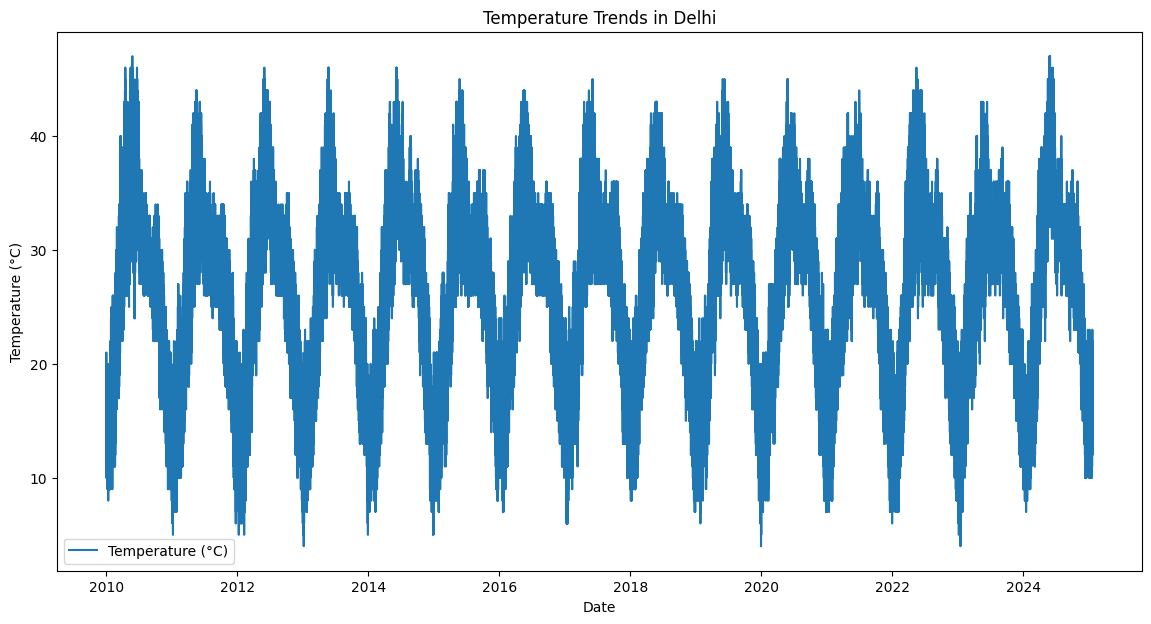

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['tempC'], label='Temperature (°C)')
plt.title('Temperature Trends in Delhi')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

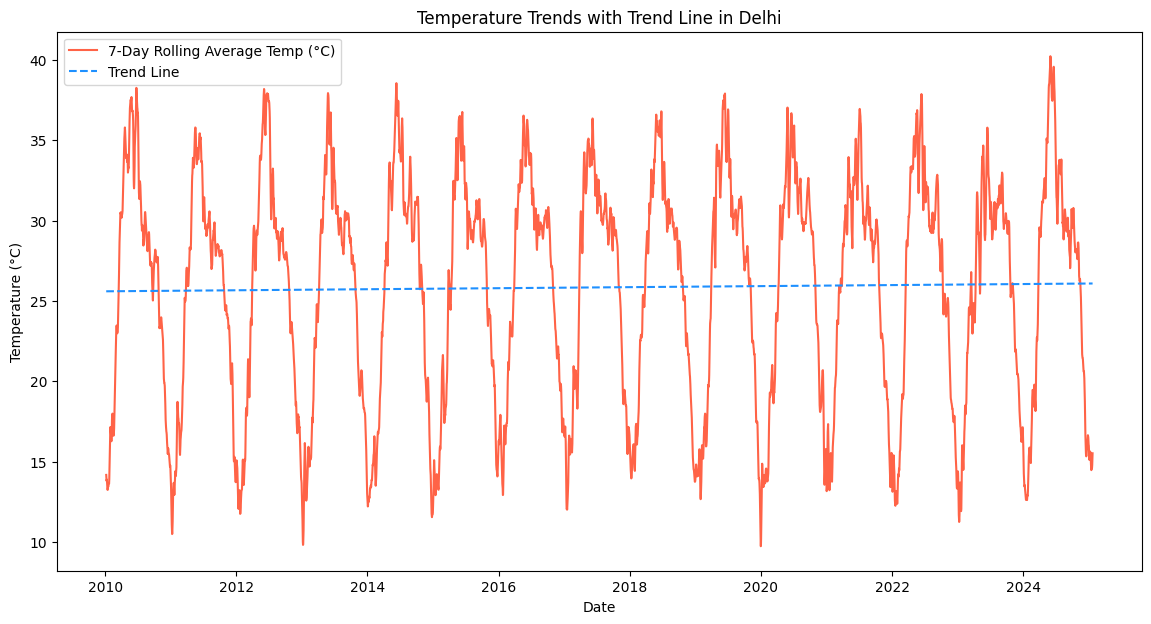

In [ ]:
df_daily = hourly_df.resample('D')['tempC'].mean().rolling(window=7).mean().dropna()
df_daily = df_daily.to_frame(name='tempC_rolling')
df_daily['tempC'] = hourly_df.resample('D')['tempC'].mean().dropna()

df_daily['date_ordinal'] = df_daily.index.map(pd.Timestamp.toordinal)

coefficients = np.polyfit(df_daily['date_ordinal'], df_daily['tempC'], 1)

polynomial = np.poly1d(coefficients)

df_daily['trend_line'] = polynomial(df_daily['date_ordinal'])

plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['tempC_rolling'], label='7-Day Rolling Average Temp (°C)', color='tomato')
plt.plot(df_daily.index, df_daily['trend_line'], label='Trend Line', color='dodgerblue', linestyle='--')
plt.title('Temperature Trends with Trend Line in Delhi')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os

In [ ]:
file_path = '/content/data/weather_data_delhi_hourly.csv'
weather_data = pd.read_csv(file_path)

In [ ]:
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

In [ ]:
weather_data.sort_values(by='date_time', inplace=True)

weather_data.reset_index(drop=True, inplace=True)

In [ ]:
weather_data['hour'] = weather_data['date_time'].dt.hour
weather_data['day_of_week'] = weather_data['date_time'].dt.dayofweek

In [ ]:
weather_data['tempC_lag1'] = weather_data['tempC'].shift(1)
weather_data.dropna(inplace=True)

In [ ]:
features = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree', 'tempC_lag1', 'hour', 'day_of_week']
scaler = MinMaxScaler()
weather_data[features] = scaler.fit_transform(weather_data[features])

In [ ]:
sequence_length = 24
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
X, y = create_sequences(weather_data[features].values, sequence_length)

df_temp = pd.DataFrame(weather_data[features].values, columns=features)

print(df_temp.head(10))

print (df_temp.shape)

      tempC  humidity  pressure  precipMM  uvIndex  windspeedKmph  \
0  0.186047  0.612245     0.700       0.0      0.0       0.294118   
1  0.162791  0.632653     0.700       0.0      0.0       0.235294   
2  0.162791  0.642857     0.700       0.0      0.0       0.176471   
3  0.162791  0.632653     0.725       0.0      0.0       0.235294   
4  0.162791  0.632653     0.725       0.0      0.0       0.294118   
5  0.139535  0.622449     0.750       0.0      0.3       0.352941   
6  0.162791  0.540816     0.750       0.0      0.3       0.323529   
7  0.232558  0.459184     0.750       0.0      0.3       0.264706   
8  0.279070  0.367347     0.750       0.0      0.4       0.235294   
9  0.348837  0.408163     0.750       0.0      0.4       0.205882   

   winddirDegree  tempC_lag1      hour  day_of_week  
0       0.869444    0.186047  0.043478     0.666667  
1       0.869444    0.186047  0.086957     0.666667  
2       0.869444    0.162791  0.130435     0.666667  
3       0.836111    0.16

In [ ]:
split_idx = int(0.8 * len(X))
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0077 - val_loss: 8.0575e-04
Epoch 2/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 9.3218e-04 - val_loss: 5.3778e-04
Epoch 3/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 7.4755e-04 - val_loss: 4.2383e-04
Epoch 4/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 6.1005e-04 - val_loss: 2.7472e-04
Epoch 5/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 5.1730e-04 - val_loss: 3.4169e-04
Epoch 6/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 4.7299e-04 - val_loss: 3.4675e-04
Epoch 7/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.6346e-04 - val_loss: 1.7117e-04
Epoch 8/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 4.4111e-04 - val_loss: 1.9931e-04
Epoch 9/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 4.4108e-04 - val_loss: 2.3704e-04
Epoch 10/35
2112/2112 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.2410e-04 - val_loss: 2.6641e-04
Epoch 11/35
2112/2112 ━━━━━━━━━━━

Model trained and saved successfully.


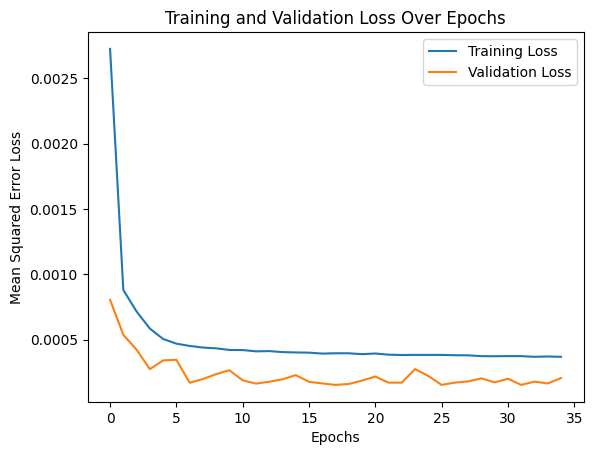

In [ ]:
if os.path.exists('lstm_weather_model.h5'):
    model = load_model('lstm_weather_model.h5')
    print("Model loaded successfully.")
else:
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, len(features))),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=35, batch_size=50, validation_data=(X_val, y_val))

    model.save('lstm_weather_model.h5')
    print("Model trained and saved successfully.")

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error Loss')
    plt.legend()
    plt.show()

In [ ]:
future_dates = pd.date_range(start='2025-01-21', end='2025-01-31', freq='h')
predictions = []

last_sequence = weather_data[features].values[-sequence_length:]

In [ ]:
for date in future_dates:

    print(f"Predicting for {date}")

    next_prediction = model.predict(last_sequence[np.newaxis, :, :])

    next_prediction = next_prediction.flatten()

    if np.isnan(next_prediction).any():
        print(f"NaN encountered at {date}, stopping prediction.")
        break
    last_sequence = np.vstack([last_sequence[1:], np.hstack([next_prediction, last_sequence[-1, 1:]])])

    predictions.append(next_prediction)

Predicting for 2025-01-21 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Predicting for 2025-01-21 01:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting for 2025-01-21 02:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting for 2025-01-21 03:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting for 2025-01-21 04:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting for 2025-01-21 05:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting for 2025-01-21 06:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicting for 2025-01-21 07:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting for 2025-01-21 08:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicting for 2025-01-21 09:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting for 2025-01-21 10:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting for 2025-01-21 11:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting for 2025-01-21 12:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting for 2025-01-21 13:00:00
1/1 ━━━━━━━━━━━

In [ ]:
predictions_array = np.array(predictions).reshape(-1, 1)
transformed_predictions = scaler.inverse_transform(np.hstack([predictions_array, np.zeros((len(predictions_array), len(features)-1))]))[:, 0]

df_predictions = pd.DataFrame({'date_time': future_dates, 'predicted_tempC': transformed_predictions})
print(df_predictions.head(20))

             date_time  predicted_tempC
0  2025-01-21 00:00:00        14.513643
1  2025-01-21 01:00:00        14.062180
2  2025-01-21 02:00:00        13.704099
3  2025-01-21 03:00:00        13.335864
4  2025-01-21 04:00:00        13.016797
5  2025-01-21 05:00:00        12.714872
6  2025-01-21 06:00:00        12.442179
7  2025-01-21 07:00:00        12.192673
8  2025-01-21 08:00:00        11.963477
9  2025-01-21 09:00:00        11.759273
10 2025-01-21 10:00:00        11.569882
11 2025-01-21 11:00:00        11.401202
12 2025-01-21 12:00:00        11.245429
13 2025-01-21 13:00:00        11.101308
14 2025-01-21 14:00:00        10.965110
15 2025-01-21 15:00:00        10.836747
16 2025-01-21 16:00:00        10.715154
17 2025-01-21 17:00:00        10.602565
18 2025-01-21 18:00:00        10.502289
19 2025-01-21 19:00:00        10.415965


In [ ]:
y_test = weather_data.loc[weather_data['date_time'].isin(future_dates), 'tempC'].values

In [ ]:
print(df_predictions.head())

            date_time  predicted_tempC
0 2025-01-21 00:00:00        14.513643
1 2025-01-21 01:00:00        14.062180
2 2025-01-21 02:00:00        13.704099
3 2025-01-21 03:00:00        13.335864
4 2025-01-21 04:00:00        13.016797


In [ ]:
y_pred_trimmed = df_predictions['predicted_tempC'].values

In [ ]:
if 'predicted_tempC' not in df_predictions.columns:
    print("Error: Column 'predicted_tempC' does not exist in df_predictions.")

In [ ]:
y_pred_trimmed = y_pred_trimmed[:24]

In [ ]:
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred_trimmed))

Length of y_test: 24
Length of y_pred: 24


In [ ]:
print("Length of y_test:", len(y_test))
print("Length of y_pred_trimmed:", len(y_pred_trimmed))

Length of y_test: 24
Length of y_pred_trimmed: 24


In [ ]:
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred_trimmed:", y_pred_trimmed.shape)

Shape of y_test: (24,)
Shape of y_pred_trimmed: (24,)


In [ ]:
print(df_predictions['predicted_tempC'].head())

0    14.513643
1    14.062180
2    13.704099
3    13.335864
4    13.016797
Name: predicted_tempC, dtype: float64


In [ ]:
y_test = weather_data.loc[weather_data['date_time'].isin(future_dates), 'tempC'].values
print("y_test:", y_test)
print("Length of y_test:", len(y_test))

y_pred_trimmed = df_predictions['predicted_tempC'].values[:len(y_test)]
print("y_pred_trimmed:", y_pred_trimmed)
print("Length of y_pred_trimmed:", len(y_pred_trimmed))

y_test: [0.25581395 0.23255814 0.23255814 0.23255814 0.20930233 0.20930233
 0.18604651 0.20930233 0.23255814 0.27906977 0.3255814  0.37209302
 0.39534884 0.41860465 0.41860465 0.41860465 0.39534884 0.37209302
 0.34883721 0.3255814  0.30232558 0.27906977 0.27906977 0.25581395]
Length of y_test: 24
y_pred_trimmed: [14.51364273 14.06217994 13.70409876 13.33586426 13.01679707 12.71487249
 12.44217893 12.19267283 11.96347722 11.75927342 11.56988184 11.4012025
 11.2454285  11.10130782 10.96511002 10.8367473  10.71515411 10.60256474
 10.50228865 10.4159649  10.34183526 10.27917889 10.22669506 10.18236221]
Length of y_pred_trimmed: 24


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_trimmed)

print("Mean Squared Error:", mse)

Mean Squared Error: 131.0587143677418


In [ ]:
hourly_df.sample(5)

,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
date_time,,,,,,,,
2011-07-27 11:00:00,32,63,1001,0.2,7,8,84,Patchy rain possible
2014-04-26 12:00:00,38,12,1007,0.0,9,16,291,Sunny
2014-06-27 06:00:00,31,38,1003,0.0,8,7,292,Sunny
2010-10-14 03:00:00,22,78,1007,0.0,1,6,327,Clear
2019-01-15 13:00:00,19,28,1017,0.0,5,13,298,Sunny


In [ ]:
if df_predictions['predicted_tempC'].max() < 100:
    df_predictions['predicted_tempC'] *= 100

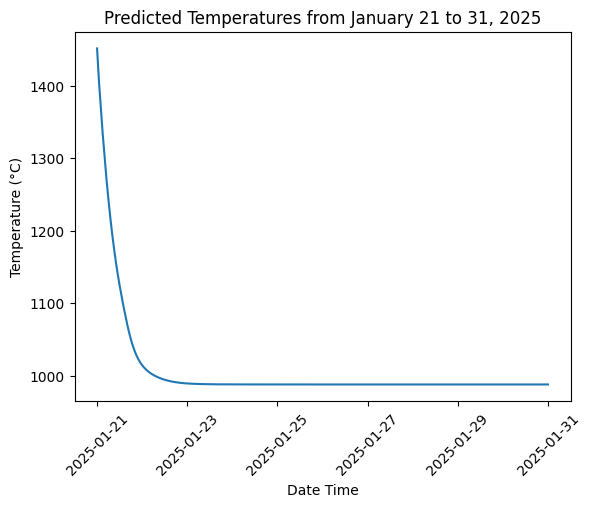

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_predictions['date_time'], df_predictions['predicted_tempC'])
plt.title('Predicted Temperatures from January 21 to 31, 2025')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

3300/3300 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


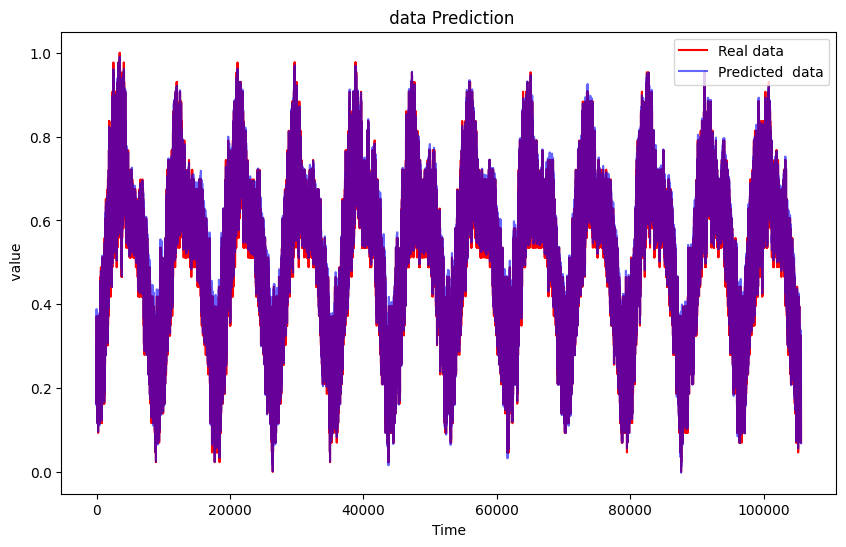

In [ ]:
prediccion = model.predict(X_train)
plt.figure(figsize=(10, 6))
plt.plot(y_train, color = 'red', label = 'Real data')t
plt.plot(prediccion, color = 'blue', label = 'Predicted  data', alpha = 0.6)
plt.title(' data Prediction')
plt.xlabel('Time')
plt.ylabel(' value')
plt.legend()
plt.show()